In [1]:
from pathlib import Path
import rioxarray as rxr
import xarray as xr

In [32]:
data_dir = Path("data/predictions")
from enum import StrEnum

class Patterns(StrEnum):
    ROOST = "Roost"
    FORAGING = "Foraging"
    ALL = "All"

pattern = Patterns.ALL

def load_predictions(
        data_dir: Path,
        pattern: Patterns,

) -> xr.DataArray:
    files = list(data_dir.glob(f"**/*{pattern}*.tif"))

    print(f"Found {len(files)} files matching pattern {pattern}")

    arrays = [
        rxr.open_rasterio(file, masked=True) for file in files
    ]
    file_ids = [
        file.stem for file in files
    ]

    array = xr.concat(arrays, dim="band")

    array = array.rename({"band": "species"})
    array = array.assign_coords(
        species= file_ids
    )
    
    return array

array = load_predictions(
    data_dir=data_dir,
    pattern=pattern
)

Found 9 files matching pattern All


In [33]:
array.rio.nodata

nan

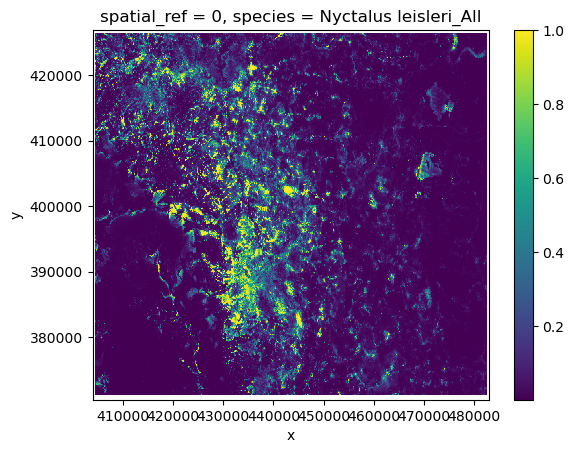

In [25]:
array[3].plot()

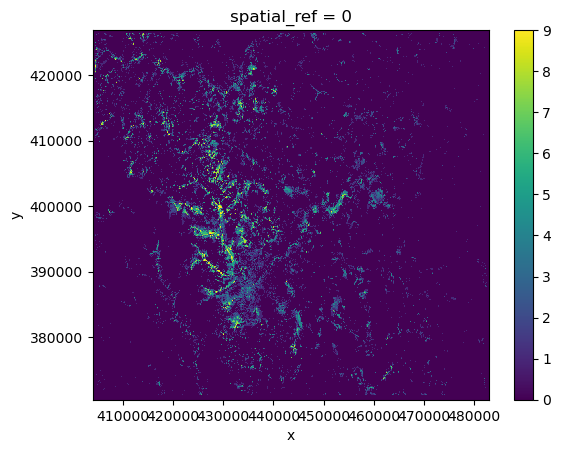

In [49]:
threshold = 0.70

threshold_str = str(threshold).replace(".", "_")
def apply_richness_threshold(array, threshold, nodata = 0):
    species_richness = (array >= threshold).sum(dim = "species")
    species_richness = species_richness.where(~array.isnull().all(dim="species"), nodata)
    species_richness = species_richness.rio.write_nodata(nodata)
    return species_richness

species_richness = apply_richness_threshold(array, threshold)
species_richness.plot()

- Clip to Sheffield & Rotheram
- output a tiff for each
- Apply a threshold to each species richness where >=6 species
- can it be added to the website?

In [50]:
species_richness.rio.nodata

0

In [51]:
import geopandas as gpd
from pyhere import here

lpa_path = here() / "data/raw/big-files/Counties_and_Unitary_Authorities_May_2023_UK_BFC_7858717830545248014.geojson"

lpas = gpd.read_file(lpa_path)
lpas = lpas.to_crs(array.rio.crs)

<Axes: >

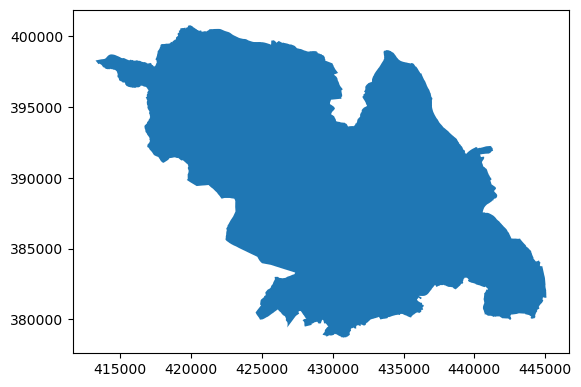

In [52]:
lpas[lpas.CTYUA23NM == "Sheffield"].geometry.plot()

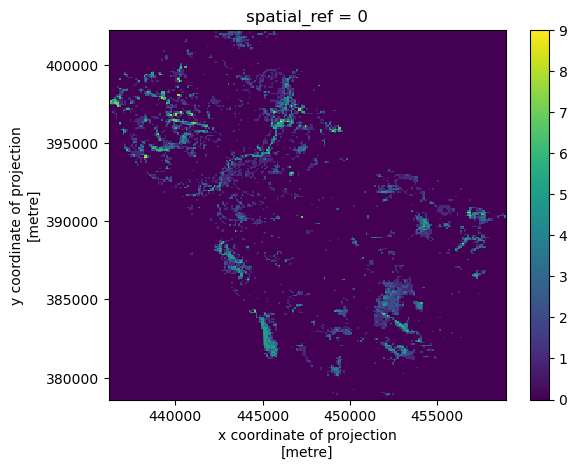

In [53]:
counties = ["Sheffield", "Rotherham"]
lpas.CTYUA23NM

def clip_to_county(array, county_gdf, county_name):
    # Filter the GeoDataFrame to get the specific county

    county = county_gdf[county_gdf["CTYUA23NM"] == county_name]
    if county.empty:
        raise ValueError(f"County {county_name} not found in the GeoDataFrame.")

    # Clip the raster data to the geometry of the county
    clipped_array = array.rio.clip(county.geometry, county.crs, drop=True)
    # mask the array to only include the area within the county
    

    return clipped_array

clipped_array = clip_to_county(species_richness, lpas, "Rotherham")

clipped_array.plot()

In [55]:
species_richness.rio.to_raster(
    f"data/species_richness_{pattern}_{threshold_str}.tif",
    driver="GTiff",
    dtype="uint8",
)